# Indian Airlines EDA and Prediction

## Import Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jagathratchakan/indian-airlines-customer-reviews")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint



## Import Dataset

In [3]:
# List files in the directory specified by the path variable
files = os.listdir(path)
print(files)

['Indian_Domestic_Airline.csv']


In [4]:
airlines_df = pd.read_csv(path + '/' + files[0])

In [5]:
airlines_df.head(10)

,AirLine_Name,Rating - 10,Title,Name,Date,Review,Recommond
0,AirAsia India,6.0,"""crew were welcoming""",V Bakshi,14th October 2023,✅ Trip Verified | I had booked this fare at a ...,yes
1,AirAsia India,1.0,"""furious and disappointed""",G Oscar,14th October 2023,✅ Trip Verified | I travel at least four times...,no
2,AirAsia India,10.0,"""amazing service and support""",Rahul Verma,14th October 2023,✅ Trip Verified | Taking this opportunity to a...,yes
3,AirAsia India,1.0,"""Waste of time and money""",G Akron,14th October 2023,✅ Trip Verified | The worst airlines in the hi...,no
4,AirAsia India,8.0,"""thumbs up to boarding crew""",Sirajudeen Jawahar ali,14th October 2023,✅ Trip Verified | Would like to give big thum...,yes
5,AirAsia India,9.0,"""Services were good""",Arpita Chatterjee,14th October 2023,Not Verified | My mother travelled alone in A...,yes
6,AirAsia India,10.0,"""thank entire staff of Air Asia""",Sharayu Parab,14th October 2023,✅ Trip Verified | I will like to thank entire...,yes
7,AirAsia India,10.0,"""impressed with her fluency""",N Padesh,14th October 2023,✅ Trip Verified | Special appreciation to the...,yes
8,AirAsia India,1.0,"""completely unacceptable behaviour""",V Krishnan,14th October 2023,✅ Trip Verified | I was supposed to be travel...,no
9,AirAsia India,8.0,"""hospitality and customer delight""",Kartika Rai,14th October 2023,✅ Trip Verified | Airline staff helped me with...,yes


# EDA

#### Exploration
Let's see how many reviews are for each airline

In [6]:
airline_counts = airlines_df['AirLine_Name'].value_counts().sort_values(ascending=False)
print(airline_counts)

AirLine_Name
AirIndia             550
SpiceJet             500
IndiGo               490
Vistara              260
Go First             180
AirAsia India        120
Air India Express    110
Name: count, dtype: int64


## Date transformation
Now let's transform the Date column to a DateTime one

In [7]:
import re
def clean_date(date_str):
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)

airlines_df['Date'] = airlines_df['Date'].apply(clean_date)
airlines_df['Date'] = pd.to_datetime(airlines_df['Date'], format='%d %B %Y')
airlines_df.head()

,AirLine_Name,Rating - 10,Title,Name,Date,Review,Recommond
0,AirAsia India,6.0,"""crew were welcoming""",V Bakshi,2023-10-14,✅ Trip Verified | I had booked this fare at a ...,yes
1,AirAsia India,1.0,"""furious and disappointed""",G Oscar,2023-10-14,✅ Trip Verified | I travel at least four times...,no
2,AirAsia India,10.0,"""amazing service and support""",Rahul Verma,2023-10-14,✅ Trip Verified | Taking this opportunity to a...,yes
3,AirAsia India,1.0,"""Waste of time and money""",G Akron,2023-10-14,✅ Trip Verified | The worst airlines in the hi...,no
4,AirAsia India,8.0,"""thumbs up to boarding crew""",Sirajudeen Jawahar ali,2023-10-14,✅ Trip Verified | Would like to give big thum...,yes


#### Top four airlines mean rating
Let's plot the Airlines mean rating, we will group the airlines that has less reviews

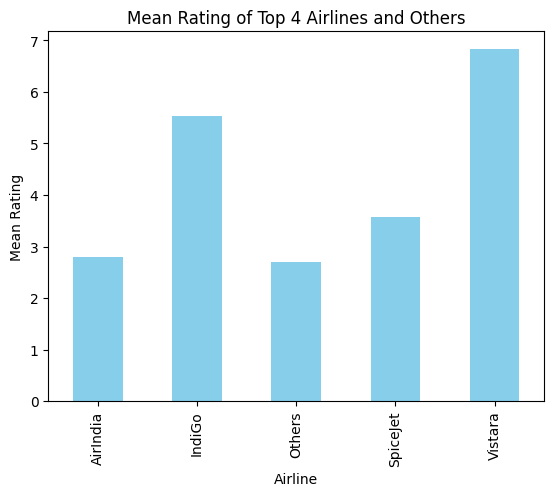

In [8]:

# Get the 4 most popular airlines
top_4_airlines = airline_counts.index[:4]

# Create a new column to categorize airlines
airlines_df['Airline_Category'] = airlines_df['AirLine_Name'].apply(lambda x: x if x in top_4_airlines else 'Others')

# Calculate mean rating for each category
mean_ratings = airlines_df.groupby('Airline_Category')['Rating - 10'].mean()

# Plot the mean ratings
mean_ratings.plot(kind='bar', color='skyblue')
plt.title('Mean Rating of Top 4 Airlines and Others')
plt.xlabel('Airline')
plt.ylabel('Mean Rating')
plt.show()

This graph show that Vistara has the best reviews and might be the best airline.

### Reviews over time
Now that we have the time correctly manipulated, we can check how the reviews change through time...

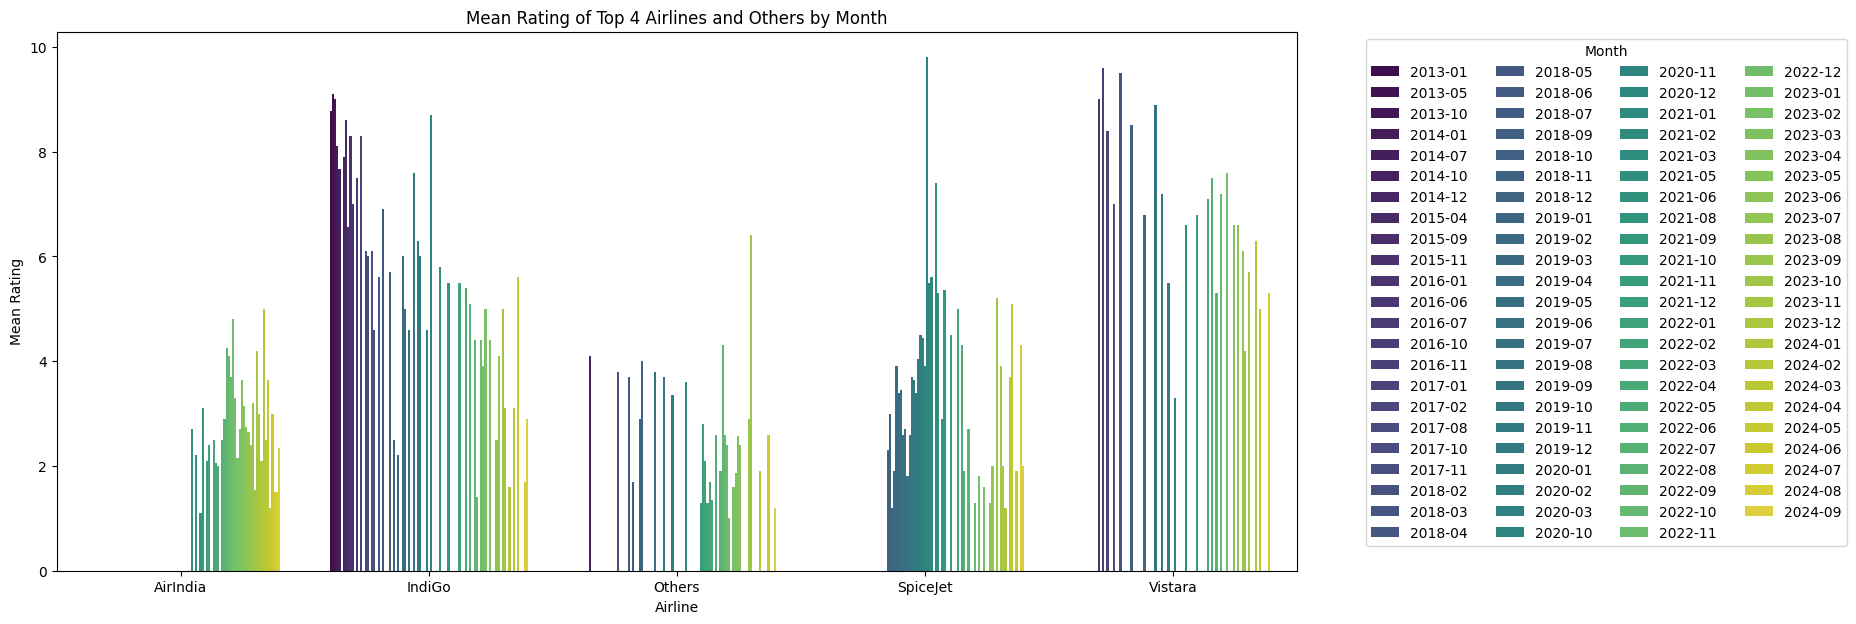

In [9]:


# Extract month from the Date column
airlines_df['Month'] = airlines_df['Date'].dt.to_period('M')

# Calculate mean rating for each category and month
mean_ratings_by_month = airlines_df.groupby(['Airline_Category', 'Month'])['Rating - 10'].mean().unstack()

# Reset the index to use it in seaborn
mean_ratings_by_month_reset = mean_ratings_by_month.reset_index()

# Melt the dataframe for seaborn
mean_ratings_melted = mean_ratings_by_month_reset.melt(id_vars='Airline_Category', var_name='Month', value_name='Mean Rating')

# Convert Month to a more readable format
mean_ratings_melted['Month'] = mean_ratings_melted['Month'].astype(str)

# Plot using seaborn with improved hue formatting
plt.figure(figsize=(16, 7))
sns.barplot(data=mean_ratings_melted, x='Airline_Category', y='Mean Rating', hue='Month', palette='viridis')
plt.title('Mean Rating of Top 4 Airlines and Others by Month')
plt.xlabel('Airline')
plt.ylabel('Mean Rating')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=4)
plt.show()

As we can see, most airlines seem to have less nice reviews in the last two years... This might mean that the services may have lower their quality.

## Text Manipulation

First let's combine the title and the review into one variable

In [10]:
airlines_df['complete_text'] = airlines_df['Title'].str.replace('"', '').str.casefold() + ' ' + airlines_df['Review'].str.casefold()
airlines_df.head()

,AirLine_Name,Rating - 10,Title,Name,Date,Review,Recommond,Airline_Category,Month,complete_text
0,AirAsia India,6.0,"""crew were welcoming""",V Bakshi,2023-10-14,✅ Trip Verified | I had booked this fare at a ...,yes,Others,2023-10,crew were welcoming ✅ trip verified | i had bo...
1,AirAsia India,1.0,"""furious and disappointed""",G Oscar,2023-10-14,✅ Trip Verified | I travel at least four times...,no,Others,2023-10,furious and disappointed ✅ trip verified | i t...
2,AirAsia India,10.0,"""amazing service and support""",Rahul Verma,2023-10-14,✅ Trip Verified | Taking this opportunity to a...,yes,Others,2023-10,amazing service and support ✅ trip verified | ...
3,AirAsia India,1.0,"""Waste of time and money""",G Akron,2023-10-14,✅ Trip Verified | The worst airlines in the hi...,no,Others,2023-10,waste of time and money ✅ trip verified | the ...
4,AirAsia India,8.0,"""thumbs up to boarding crew""",Sirajudeen Jawahar ali,2023-10-14,✅ Trip Verified | Would like to give big thum...,yes,Others,2023-10,thumbs up to boarding crew ✅ trip verified | ...


Now we want to get rid of the trip verified var as it will make noise in our predictions

In [11]:
# Remove trip verified
airlines_df['complete_text'] = airlines_df['complete_text'].str.replace("✅ trip verified | ", "")
airlines_df['complete_text'] = airlines_df['complete_text'].str.replace("not verified | ", "")

# Remove special characters
airlines_df['complete_text'] = airlines_df['complete_text'].str.replace(r'[^\w\s]', '', regex=True)

In [12]:
airlines_df['complete_text'].head()

0    crew were welcoming i had booked this fare at ...
1    furious and disappointed i travel at least fou...
2    amazing service and support taking this opport...
3    waste of time and money the worst airlines in ...
4    thumbs up to boarding crew  would like to give...
Name: complete_text, dtype: object

## Preparation for Model Input

First we will encode the Airline's name.

In [13]:
# Initialize the LabelEncoder
label_encoder_names = LabelEncoder()

# Fit and transform the AirLine_Name column
airlines_df['AirLine_Name_Encoded'] = label_encoder_names.fit_transform(airlines_df['AirLine_Name'])

# Display the first few rows to verify the encoding
airlines_df.head()

,AirLine_Name,Rating - 10,Title,Name,Date,Review,Recommond,Airline_Category,Month,complete_text,AirLine_Name_Encoded
0,AirAsia India,6.0,"""crew were welcoming""",V Bakshi,2023-10-14,✅ Trip Verified | I had booked this fare at a ...,yes,Others,2023-10,crew were welcoming i had booked this fare at ...,1
1,AirAsia India,1.0,"""furious and disappointed""",G Oscar,2023-10-14,✅ Trip Verified | I travel at least four times...,no,Others,2023-10,furious and disappointed i travel at least fou...,1
2,AirAsia India,10.0,"""amazing service and support""",Rahul Verma,2023-10-14,✅ Trip Verified | Taking this opportunity to a...,yes,Others,2023-10,amazing service and support taking this opport...,1
3,AirAsia India,1.0,"""Waste of time and money""",G Akron,2023-10-14,✅ Trip Verified | The worst airlines in the hi...,no,Others,2023-10,waste of time and money the worst airlines in ...,1
4,AirAsia India,8.0,"""thumbs up to boarding crew""",Sirajudeen Jawahar ali,2023-10-14,✅ Trip Verified | Would like to give big thum...,yes,Others,2023-10,thumbs up to boarding crew would like to give...,1


Now we will tokenize the complete_text

In [14]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the complete_text column
tokenizer.fit_on_texts(airlines_df['complete_text'])

# Tokenize the complete_text column
airlines_df['tokenized_text'] = tokenizer.texts_to_sequences(airlines_df['complete_text'])

# The text with most words
max_words = max(airlines_df['complete_text'].apply(lambda x: len(x.split())))

# Pad the tokenized sequences
airlines_df['tokenized_text'] = pad_sequences(airlines_df['tokenized_text'], maxlen=max_words, padding='pre').tolist()

# Display the first few rows to verify the tokenization
airlines_df[['complete_text', 'tokenized_text']].head()

print(max_words)

689


We will get the max length of the tokenized_text (Should be the same as max_words) and the max_token_value (This is how many words where encoded)... We will use them then to create the model

In [15]:
# Get the maximum length of the sequences
max_len_combined_text = max_words
print(f'Max length of combined_text: {max_len_combined_text}')

max_token_value = max(max(seq) for seq in airlines_df['tokenized_text'] if seq)
print(f'Max token value in sequences: {max_token_value}')

Max length of combined_text: 689
Max token value in sequences: 9633


## Preparation for Model target

The model will try to guess if the review was rated as a good one or a bad one, and also try to guess if they recommend the airline or not. (Two outputs)<br>
First we will encode the recommendation (Should be either yes or no (0 or 1))

In [16]:
# Initialize the LabelEncoder
label_encoder_recommend = LabelEncoder()

# Fit and transform the AirLine_Name column
airlines_df['Recommond_encoded'] = label_encoder_recommend.fit_transform(airlines_df['Recommond'])

# Display the first few rows to verify the encoding
airlines_df.head()

,AirLine_Name,Rating - 10,Title,Name,Date,Review,Recommond,Airline_Category,Month,complete_text,AirLine_Name_Encoded,tokenized_text,Recommond_encoded
0,AirAsia India,6.0,"""crew were welcoming""",V Bakshi,2023-10-14,✅ Trip Verified | I had booked this fare at a ...,yes,Others,2023-10,crew were welcoming i had booked this fare at ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,AirAsia India,1.0,"""furious and disappointed""",G Oscar,2023-10-14,✅ Trip Verified | I travel at least four times...,no,Others,2023-10,furious and disappointed i travel at least fou...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,AirAsia India,10.0,"""amazing service and support""",Rahul Verma,2023-10-14,✅ Trip Verified | Taking this opportunity to a...,yes,Others,2023-10,amazing service and support taking this opport...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,AirAsia India,1.0,"""Waste of time and money""",G Akron,2023-10-14,✅ Trip Verified | The worst airlines in the hi...,no,Others,2023-10,waste of time and money the worst airlines in ...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,AirAsia India,8.0,"""thumbs up to boarding crew""",Sirajudeen Jawahar ali,2023-10-14,✅ Trip Verified | Would like to give big thum...,yes,Others,2023-10,thumbs up to boarding crew would like to give...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


Now we will converted to a categorical output

In [17]:
g_target_1 = to_categorical(airlines_df['Recommond_encoded'])
g_target_1[:3]

array([[0., 1.],
       [1., 0.],
       [0., 1.]])

Let's see what we have in 'Rating - 10'

In [18]:
airlines_df['Rating - 10'].unique()

array([ 6.,  1., 10.,  8.,  9.,  7.,  2.,  5.,  3.,  4., nan])

As we can see we have nan values, let's change them for 0.

In [19]:
airlines_df['Rating - 10'] = airlines_df['Rating - 10'].fillna(0)

Now we will also change it to a categorical output

In [20]:
g_target_2 = to_categorical(airlines_df['Rating - 10'])

Let's see the shape of our target...

In [21]:
print ('g_target_1 shape:', g_target_1.shape)
print ('g_target_2 shape:', g_target_2.shape)

g_target_1 shape: (2210, 2)
g_target_2 shape: (2210, 11)


As we can see, they have the same shape[0], we then can concatenate them in order to make splitting later.

In [22]:
# NOTE: Remember that g_target_1 is the first 2 columns (0 (no), 1 (yes)) and g_target_2 is the next 11 columns (Between 0 and 10 rating)
g_target = np.concatenate([g_target_1, g_target_2], axis=1)
print ('g_target shape:', g_target.shape)

g_target shape: (2210, 13)


We will also concat the tokenized text and the encoded airline name

In [23]:
airline_name = airlines_df['AirLine_Name_Encoded'].to_numpy()
combined_text = airlines_df['tokenized_text'].to_numpy()

print ('airline_name shape:', airline_name.shape)
print ('combined_text shape:', combined_text.shape)

airline_name shape: (2210,)
combined_text shape: (2210,)


In [24]:
airline_name[:3]

array([1, 1, 1])

In [25]:
combined_text[:3]

array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

As we can see, airline name and airline text are different types... We should unravel the list to concatenate them.

In [26]:
# Unravel combined_text
unraveled_combined_text = np.array([item for sublist in combined_text for item in sublist])

# Reshape unraveled_combined_text to match the shape of AirLine_Name_Encoded
unraveled_combined_text = unraveled_combined_text.reshape(airline_name.shape[0], -1)

# Concatenate AirLine_Name_Encoded and unraveled_combined_text along the second axis
features = np.concatenate([airline_name.reshape(-1, 1), unraveled_combined_text], axis=1)

features[:3]

array([[  1,   0,   0, ..., 545, 182,  64],
       [  1,   0,   0, ...,  12,  36, 172],
       [  1,   0,   0, ...,  11, 391,  82]])

Now we have two inputs together and two outputs together, we can train_test_split them

In [27]:
# Split the data into train and test sets
input_train, input_test, targets_train, targets_test = train_test_split(features, g_target, test_size=0.2, random_state=42)

# Further split the train set into train and validation sets
input_train, input_val, targets_train, targets_val = train_test_split(input_train, targets_train, test_size=0.25, random_state=42)


# Display the shapes of the resulting datasets
print("Train input shape:", input_train.shape)
print("Validation input shape:", input_val.shape)
print("Test input shape:", input_test.shape)
print("Train target shape:", targets_train.shape)
print("Validation target shape:", targets_val.shape)
print("Test target shape:", targets_test.shape)

Train input shape: (1326, 690)
Validation input shape: (442, 690)
Test input shape: (442, 690)
Train target shape: (1326, 13)
Validation target shape: (442, 13)
Test target shape: (442, 13)


In [28]:
print("Train features 1:", input_train[0, 0]) # Airline Name
print("Train features 2:", input_train[0, 1:]) # Combined Text
print("Train Target 1:", targets_train[0, :2]) # Recommond
print("Train Target 2:", targets_train[0 , 2:]) # Rating


Train features 1: 5
Train features 2: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

## Model Design
We can't use sequential for this model as it will have two outputs, instead we can create the model from scratch using the layers

In [29]:
# Define the model

# Input for the airline name and combined text

checkpoint = ModelCheckpoint('NLP/Keras-Tensorflow/Airlines reviews prediction/best_model.weights.h5', monitor='val_rating_output_accuracy', save_best_only=True, mode='max', save_weights_only=True)
airline_input = Input(shape=(1,), name='airline_input')
text_input = Input(shape=(max_words,), name='text_input')
embedding_layer = Embedding(
        max_token_value,
        128,
        trainable=True,
    ) (text_input)
sp_d1 = SpatialDropout1D(0.2)(embedding_layer)
LSTM_Layer_1 = LSTM(256, dropout=0.2, return_sequences=True)(sp_d1)
dropout = tf.keras.layers.Dropout(0.2)(LSTM_Layer_1)
LSTM_Layer_2 = LSTM(128, dropout=0.2)(dropout)
# Concatenate the LSTM output with the airline input
concatenated = tf.keras.layers.Concatenate()([LSTM_Layer_2, airline_input])
# Output layers
Output_Layer_1 = Dense(11, activation='softmax', name='rating_output')(concatenated)
Output_Layer_2 = Dense(2, activation='softmax', name='recommend_output')(concatenated)

model = Model(inputs=[airline_input, text_input], outputs=[Output_Layer_1, Output_Layer_2])



# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy','accuracy'])

# Display the model summary
model.summary()

# Train the model with more epochs
history = model.fit([input_train[:, 0], input_train[:, 1:]], [targets_train[:, 2:], targets_train[:, :2]], epochs=50, batch_size=32, validation_data=([input_val[:, 0], input_val[:, 1:]], [targets_val[:, 2:], targets_val[:, :2]]), callbacks=[checkpoint])



I0000 00:00:1729049746.652209 1030804 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729049746.871065 1030804 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729049746.871614 1030804 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729049746.876026 1030804 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729049746.876381 1030804 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 689)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 689, 128)  │  1,233,024 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 689, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 689, 256)  │    394,240 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 689, 256)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    197,120 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ airline_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 129)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ airline_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_output       │ (None, 11)        │      1,430 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ recommend_output    │ (None, 2)         │        260 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,826,074 (6.97 MB)

 Trainable params: 1,826,074 (6.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 2.8483 - rating_output_accuracy: 0.3317 - rating_output_loss: 2.1705 - recommend_output_accuracy: 0.6312 - recommend_output_loss: 0.6779 - val_loss: 2.4874 - val_rating_output_accuracy: 0.4480 - val_rating_output_loss: 1.8572 - val_recommend_output_accuracy: 0.6471 - val_recommend_output_loss: 0.6324
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 2.2503 - rating_output_accuracy: 0.4667 - rating_output_loss: 1.7364 - recommend_output_accuracy: 0.7323 - recommend_output_loss: 0.5136 - val_loss: 1.8565 - val_rating_output_accuracy: 0.5249 - val_rating_output_loss: 1.5220 - val_recommend_output_accuracy: 0.8439 - val_recommend_output_loss: 0.3420
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 1.6110 - rating_output_accuracy: 0.5547 - rating_output_loss: 1.3984 - recommend_output_accuracy: 0.9199 - recommend_output_loss: 0.2128 - val_loss: 1.8143 - val_rating_output_accuracy: 0.5249 - val_rating_output_lo

This model input a set of variables (The airline encoded and the text) and output another set of variables (The Rating and the Recommend)<br>
Now let's load the best model values before continuing

In [30]:
model.load_weights('NLP/Keras-Tensorflow/Airlines reviews prediction/best_model.weights.h5')

# Predictions on Test

In [37]:
preds = model.predict([input_test[:, 0], input_test[:, 1:]])
loss, rating_loss, review_loss, rating_accuracy, review_accuracy = model.evaluate([input_test[:, 0], input_test[:, 1:]], [targets_test[:, 2:], targets_test[:, :2]])

print("Model evaluation on test data")
print("Test accuracy for rating:", rating_accuracy)
print("Test accuracy for review:", review_accuracy)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.7991 - rating_output_accuracy: 0.5552 - rating_output_loss: 1.4775 - recommend_output_accuracy: 0.9097 - recommend_output_loss: 0.3218
Model evaluation on test data
Test accuracy for rating: 0.5610859990119934
Test accuracy for review: 0.918552041053772


As we can see, the model perform better in review (yes or no) than in rating (0 to 10)

Now let's unpack the predictions...

In [46]:
rating_pred = np.argmax(preds[0], axis=1)
recommend_pred = np.argmax(preds[1], axis=1)

And also let's unpack the test real results

In [42]:
rating_real = np.argmax(targets_test[:, 2:], axis=1)
recommend_real = np.argmax(targets_test[:, :2], axis=1)

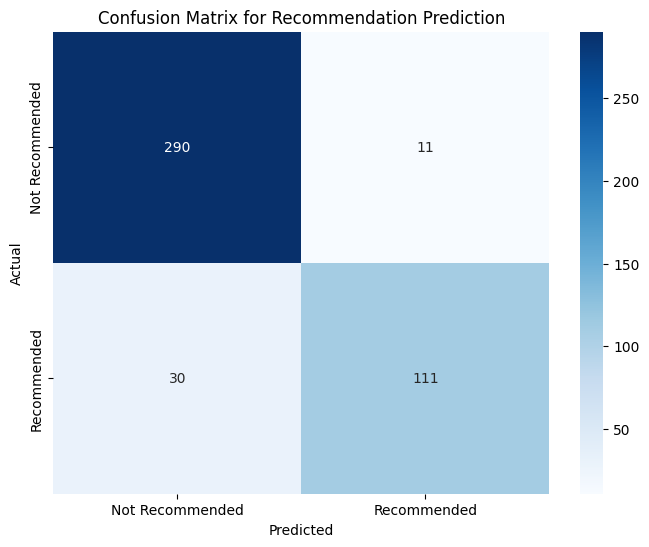

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(recommend_real, recommend_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Recommended', 'Recommended'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Recommendation Prediction')
plt.show()

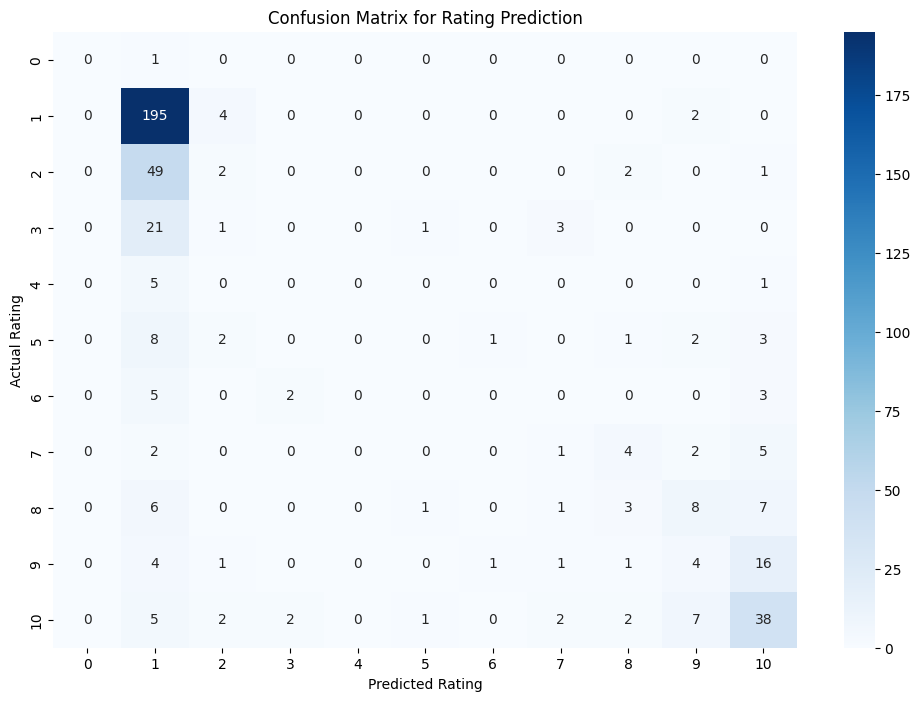

In [47]:
# Create the confusion matrix for rating prediction
conf_matrix_rating = confusion_matrix(rating_real, rating_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_rating, annot=True, fmt='d', cmap='Blues', xticklabels=range(11), yticklabels=range(11))
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Confusion Matrix for Rating Prediction')
plt.show()

## Conclusion

In this notebook, we performed an extensive exploratory data analysis (EDA) and built a predictive model to analyze customer reviews of Indian airlines. Here are the key steps and findings:

1. **Exploratory Data Analysis (EDA)**:
    - We explored the distribution of reviews across different airlines and visualized the mean ratings of the top four airlines.
    - We observed that Vistara had the best reviews among the airlines.
    - We also analyzed the trend of reviews over time, noting a decline in review quality in recent years.

2. **Text Manipulation**:
    - We combined the title and review text into a single variable and removed unnecessary text and special characters to prepare the data for modeling.

3. **Feature Engineering**:
    - We encoded the airline names and tokenized the review text.
    - We prepared the input features and target variables for the model, including encoding the recommendation and rating columns.

4. **Model Design and Training**:
    - We designed a neural network model with LSTM layers to handle the sequential nature of the text data.
    - The model was trained to predict both the rating and recommendation of the reviews.
    - We used a checkpoint to save the best model weights during training.

5. **Model Evaluation**:
    - The model was evaluated on the test set, showing better performance in predicting recommendations compared to ratings.
    - Confusion matrices were plotted to visualize the model's performance on both tasks.
